In [4]:
import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

from os import path
import matplotlib.pyplot as plt
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from utils.postprocessing.config import Config

import seaborn as sns

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [78]:
MAP_NAME = 'slope_rocks1'
MAPS_DIR = '/home/francesco/Documents/Master-Thesis/core/maps/train/'

In [79]:
csvs_paths = glob.glob('/home/francesco/Desktop/carino/vaevictis/data/train/csvs/{}/*.csv'.format(MAP_NAME))
# csvs_paths = glob.glob('/home/francesco/Desktop/data/csv/querry/*.csv')
len(csvs_paths)

89

[[  0   0   0 ...  12  12  12]
 [  0   0   0 ...  12  12  12]
 [  0   0   0 ...  12  12  12]
 ...
 [240 240 240 ... 252 252 252]
 [241 241 241 ... 253 253 253]
 [242 242 242 ... 254 254 254]]


<IPython.core.display.Javascript object>


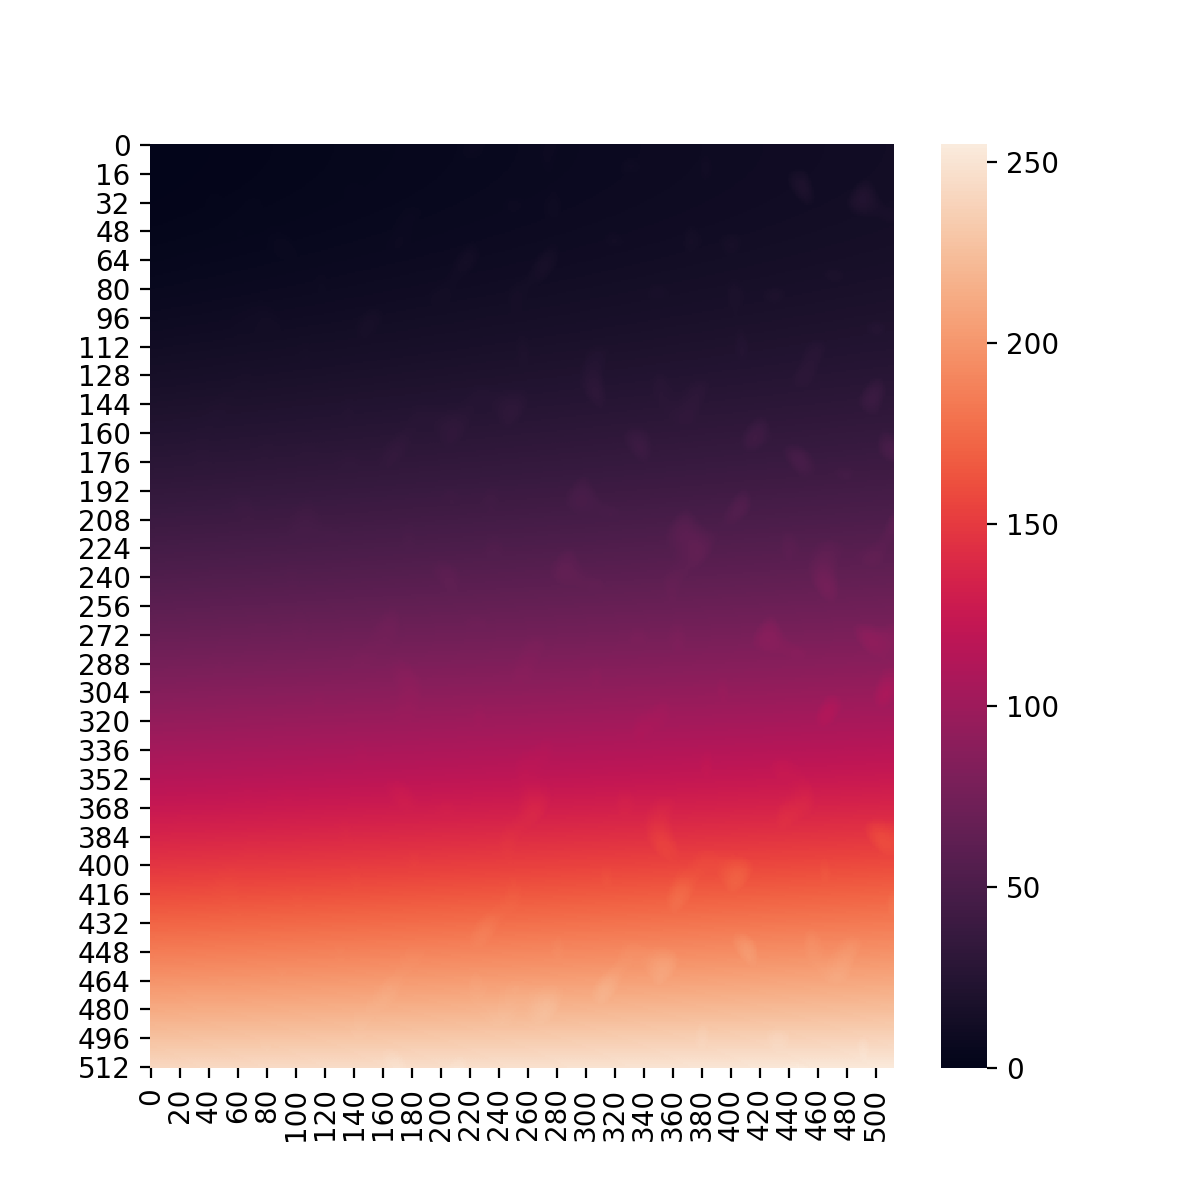

In [80]:
hm = cv2.imread('{}/{}.png'.format(MAPS_DIR, MAP_NAME))
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

print(hm)
fig = plt.figure()
sns.heatmap(hm)
plt.show()

## Visualize the robot's trace
Below we plotted all the robot's positions for the given map

In [81]:
dfs = csvs2dfs(csvs_paths)

In [21]:
plt.rcParams['figure.figsize'] = (6,6)

<IPython.core.display.Javascript object>


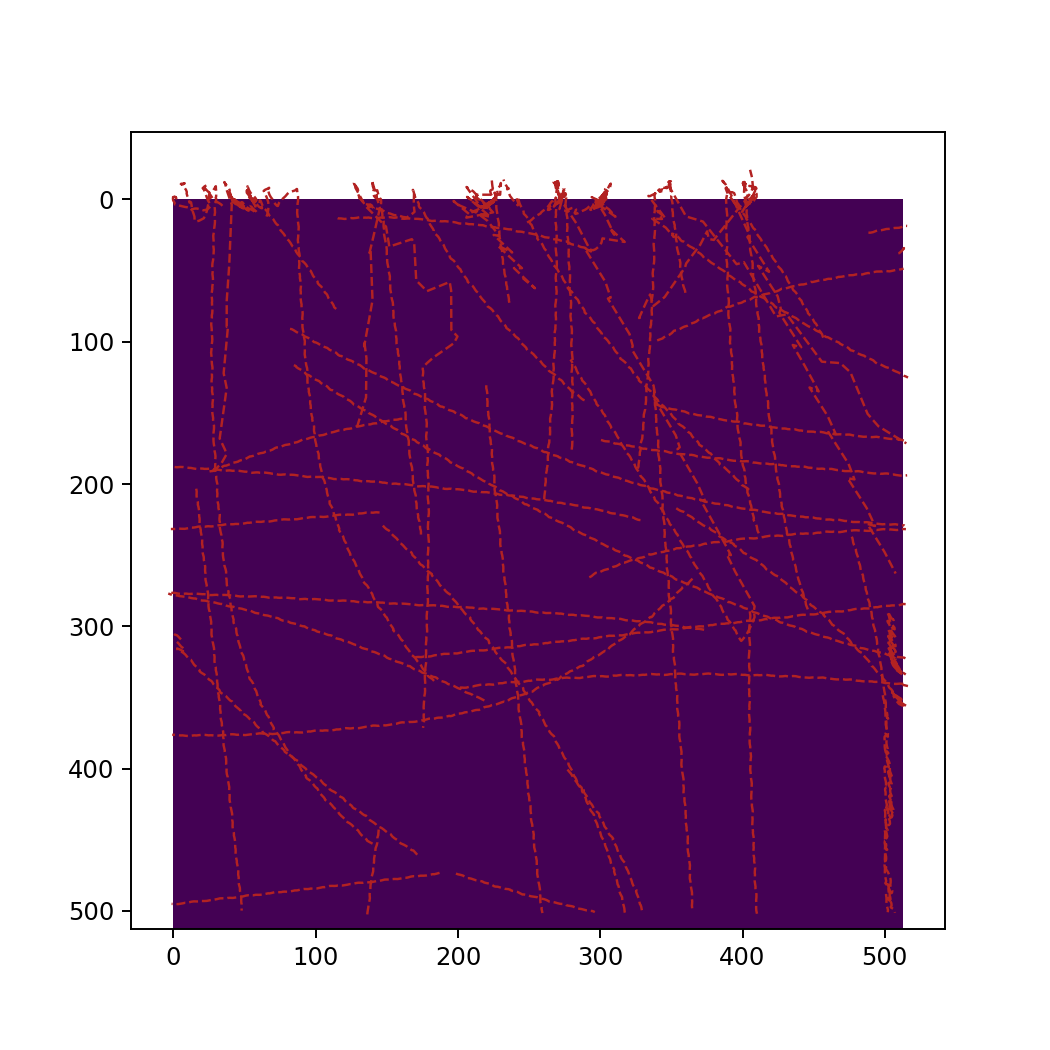

<IPython.core.display.Javascript object>


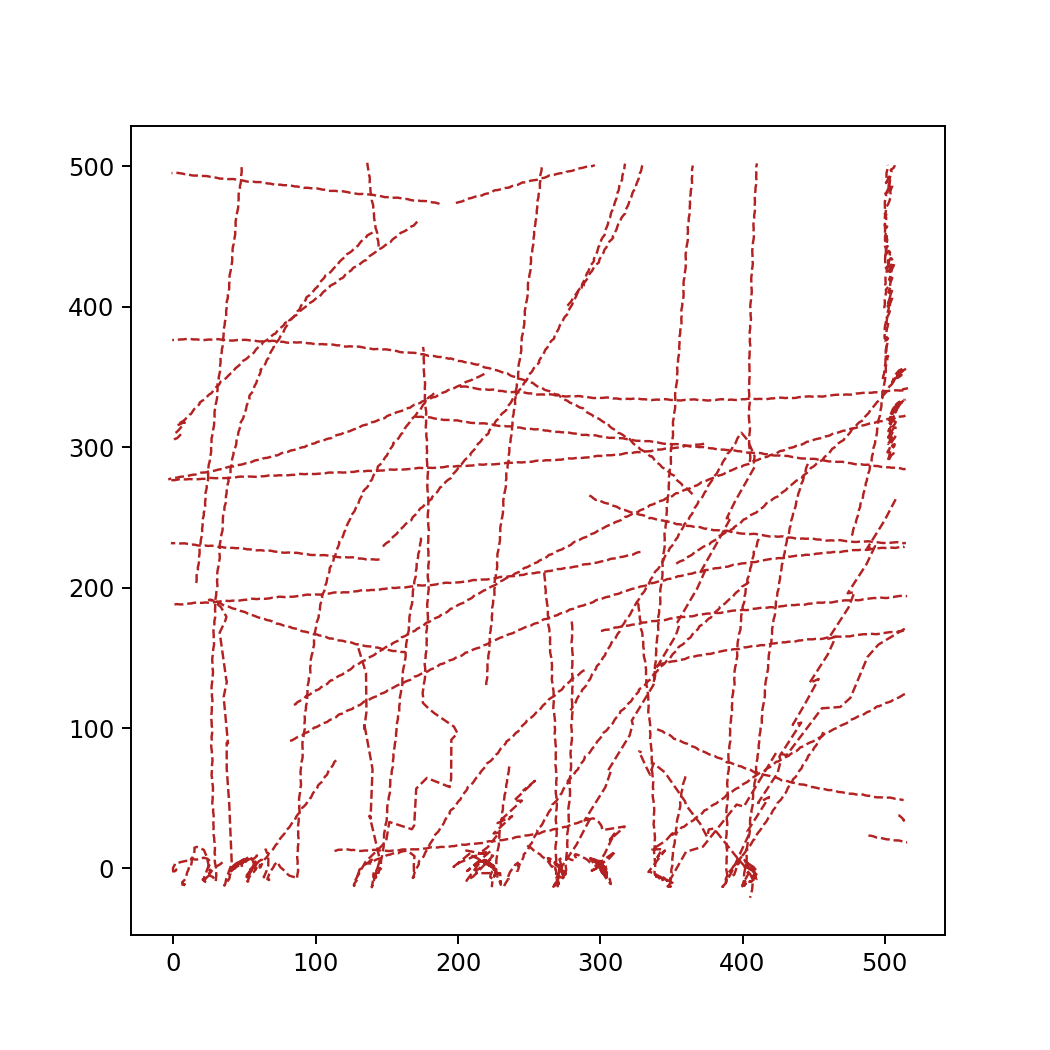

In [22]:
show_traces(dfs, hm)
show_naked_traces(dfs)

## Plotting statistics

In [33]:
df_total = pd.concat(filter(lambda x: len(x) > 0, dfs))
df_total = df_total.dropna()
df_total = df_total.reset_index() # we need to reset the index otherwise the plots are based on the old overlapping indexes

### Advancement
Below we show a box plot of the advancement

<IPython.core.display.Javascript object>


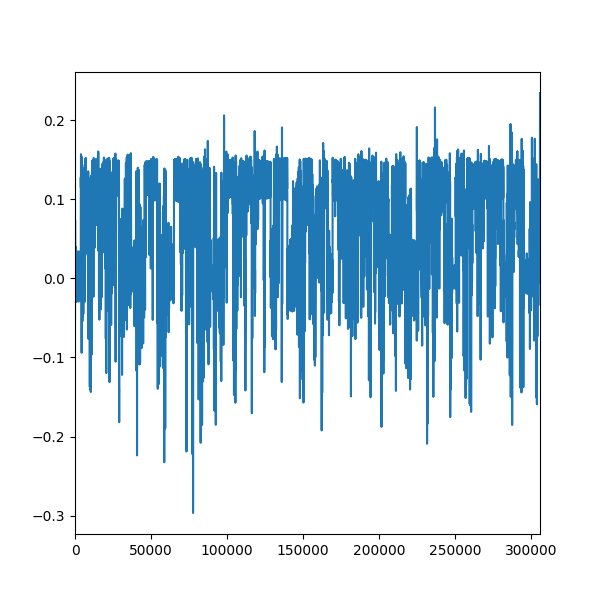

In [34]:
fig = plt.figure()
df_total['advancement'].plot.line()

<IPython.core.display.Javascript object>


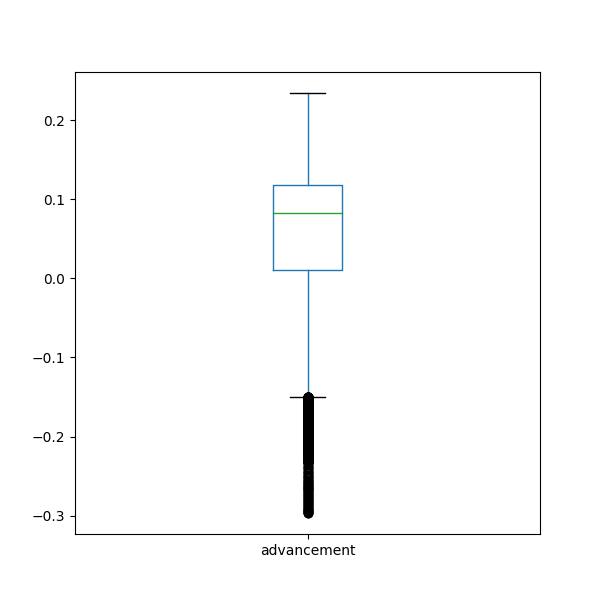

0.06350765143329709

In [35]:
fig = plt.figure()
df_total['advancement'].plot.box()
df_total['advancement'].mean()

In [26]:
df_total['advancement'].min()

-0.2966186979486025

# Debug

In [13]:
from utils.visualisation import *
from utils.postprocessing.utils import *

In [65]:
class DebugPipeline():
    def __init__(self, hm):
        self.hm = hm
        self.patch_size = 100 // 2

    @property
    def hm_ax(self):
        fig = plt.figure()
        plt.title('Map')
        ax = sns.heatmap(hm)
        return ax 
    
    def show_map(self, hm):
        self.hm_ax
        plt.show()
    
    def show_trace(self, df):
        initial_pos = df.hm_x[0], df.hm_y[0]
        last_position = df.hm_x.iloc[-1], df.hm_y.iloc[-1]
        print(last_position)
        ax = self.hm_ax
        ax.plot(*initial_pos, marker='o', color='g', ls='', label='start')
        ax.plot(*last_position, marker='o', color='r', ls='', label='finish')
        ax.plot(df.hm_x,  df.hm_y, '--', linewidth=2, color='white', label='path')
        ax.legend()
    
    def show_patches(self, df, center=False, n_samples=4, scale=1):
        fig = plt.figure(figsize=(6, 6))
        
        sample = df.sample(n_samples)
        fig, ax = plt.subplots(nrows=n_samples // 2, ncols=n_samples // 2)
        fig.suptitle('patches center={}'.format(center))
        for row in ax:
            for idx, (col, (i, row)) in enumerate(zip(row, sample.iterrows())):
                x, y = row["hm_x"],row["hm_y"]
                patch, _ = hmpatch(self.hm, x, y,np.rad2deg(row['pose__pose_position_z']),  self.patch_size,scale=1)
                patch = patch.astype(np.float32)
                if center: patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]
#                 patch = (patch * 255) 
                    
                col.plot(self.patch_size // 2, self.patch_size // 2, marker='o', color='r', ls='', linewidth=10, label='finish')                
                sns.heatmap(patch, ax=col)
        
        plt.show()
        
        
    def show_patch_on_the_map(self, sample):
        fig = plt.figure(figsize=(6, 12))
        x, y, ang, ad = sample["hm_x"], \
            sample["hm_y"], \
            sample['pose__pose_position_z'], \
            sample["advancement"]

        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        ax1.set_title("advancement: {:.4f}, x={:.0f}, y={:.0f}".format(ad, 
                                                                      x,
                                                                      y))
        sns.heatmap(self.hm, ax=ax1)
        rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
                                 self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
    
        patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
        sns.heatmap(patch, ax=ax2)
        
        
    def show_patches_on_the_map(self, df):
        n_show = 3
        subset = df.loc[list(range(0, len(df), len(df) // n_show)), :]
        
        for sample in subset.iterrows():
            self.show_patch_on_the_map(sample[1])
            
    def show_traversability_in_time(self, df):
        fig = plt.figure()
        plt.plot(df['advancement'])
        plt.show()
        
    def __call__(self, df):
#         self.show_map(self.hm)
        self.show_trace(df)
#         self.show_patches(df)
#         self.show_patches(df, center=True, scale=10)
#         self.show_patches_on_the_map(df)
#         self.show_patches(df.sort_values("advancement").head(4), n_samples=4)
#         self.show_patches(df.sort_values("advancement").tail(4), n_samples=4)

        self.show_traversability_in_time(df)
        
        

(369.34986953097916, 289.1245952213393)


<IPython.core.display.Javascript object>


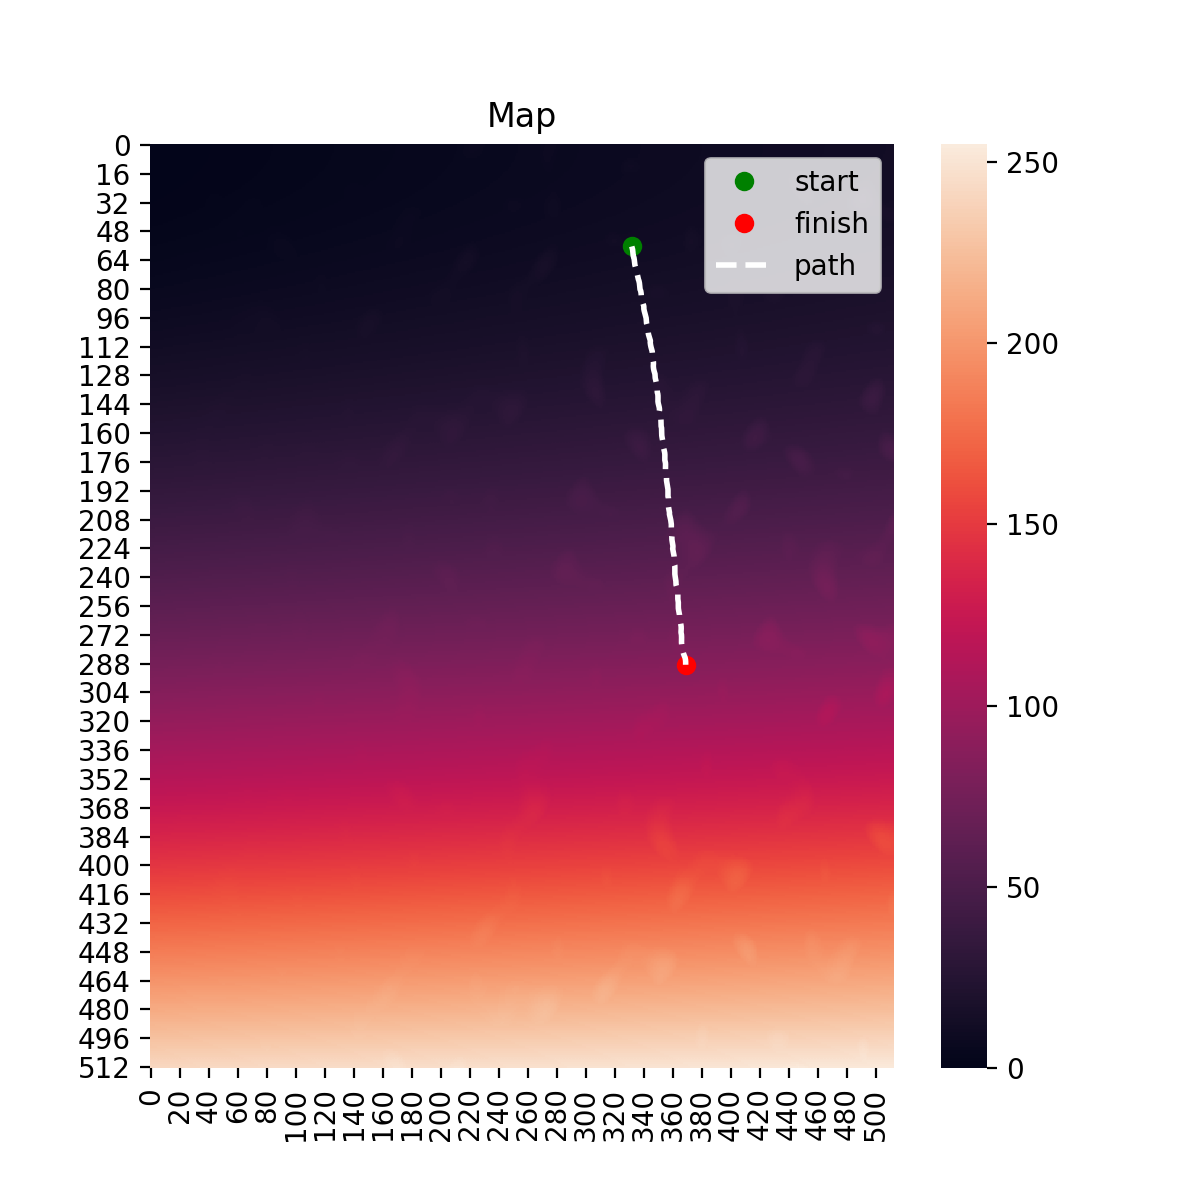

<IPython.core.display.Javascript object>


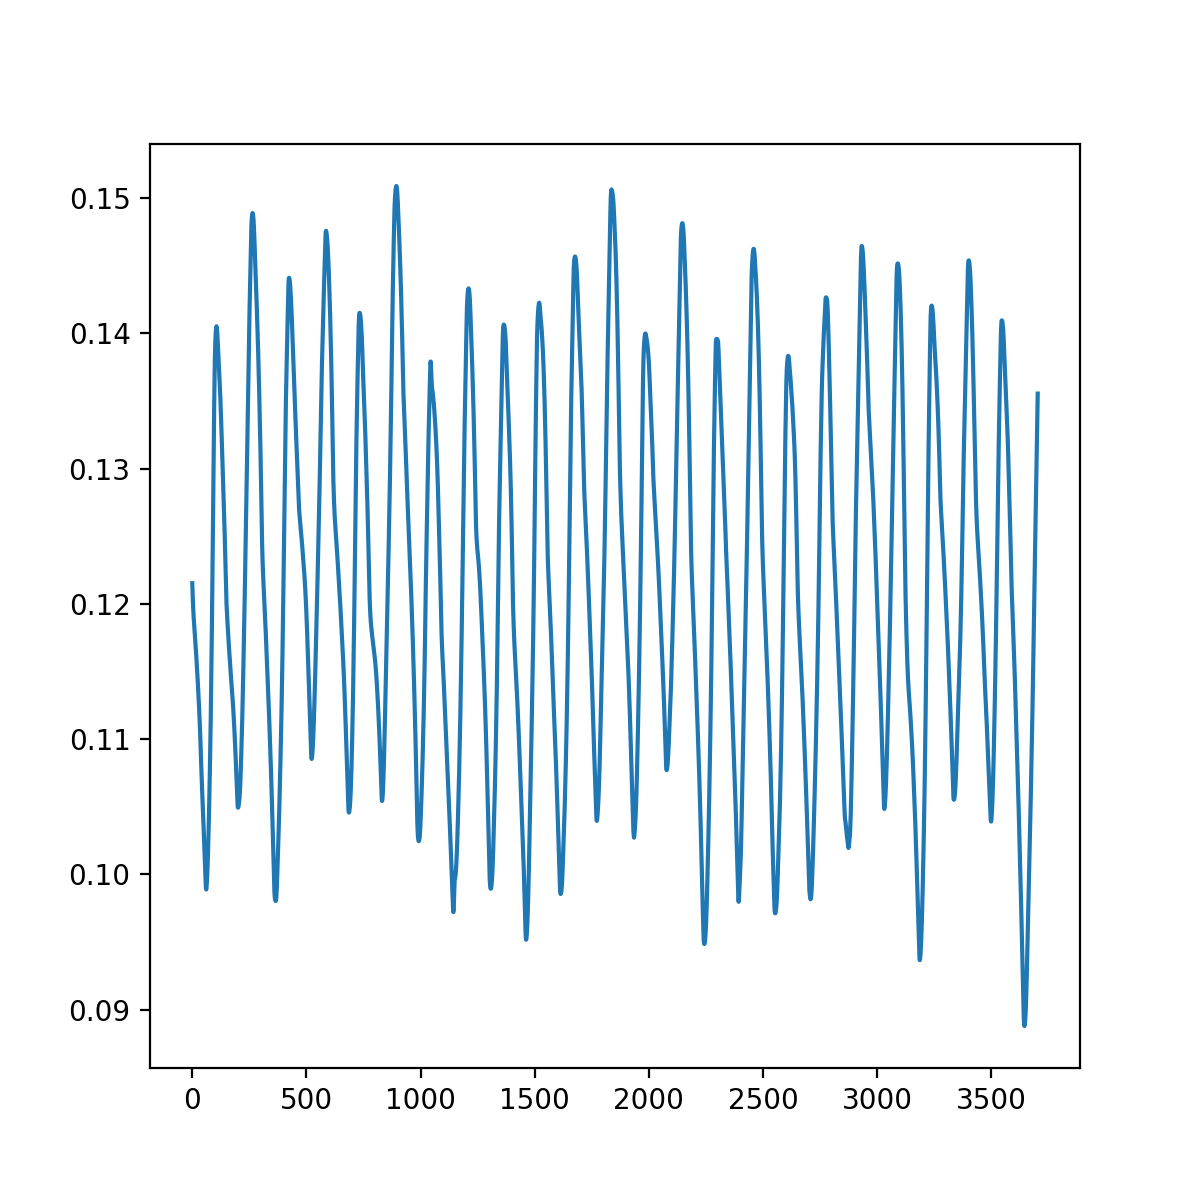

In [83]:
deb_pip = DebugPipeline(hm)
curr_df = dfs[2]
deb_pip(curr_df)



<IPython.core.display.Javascript object>


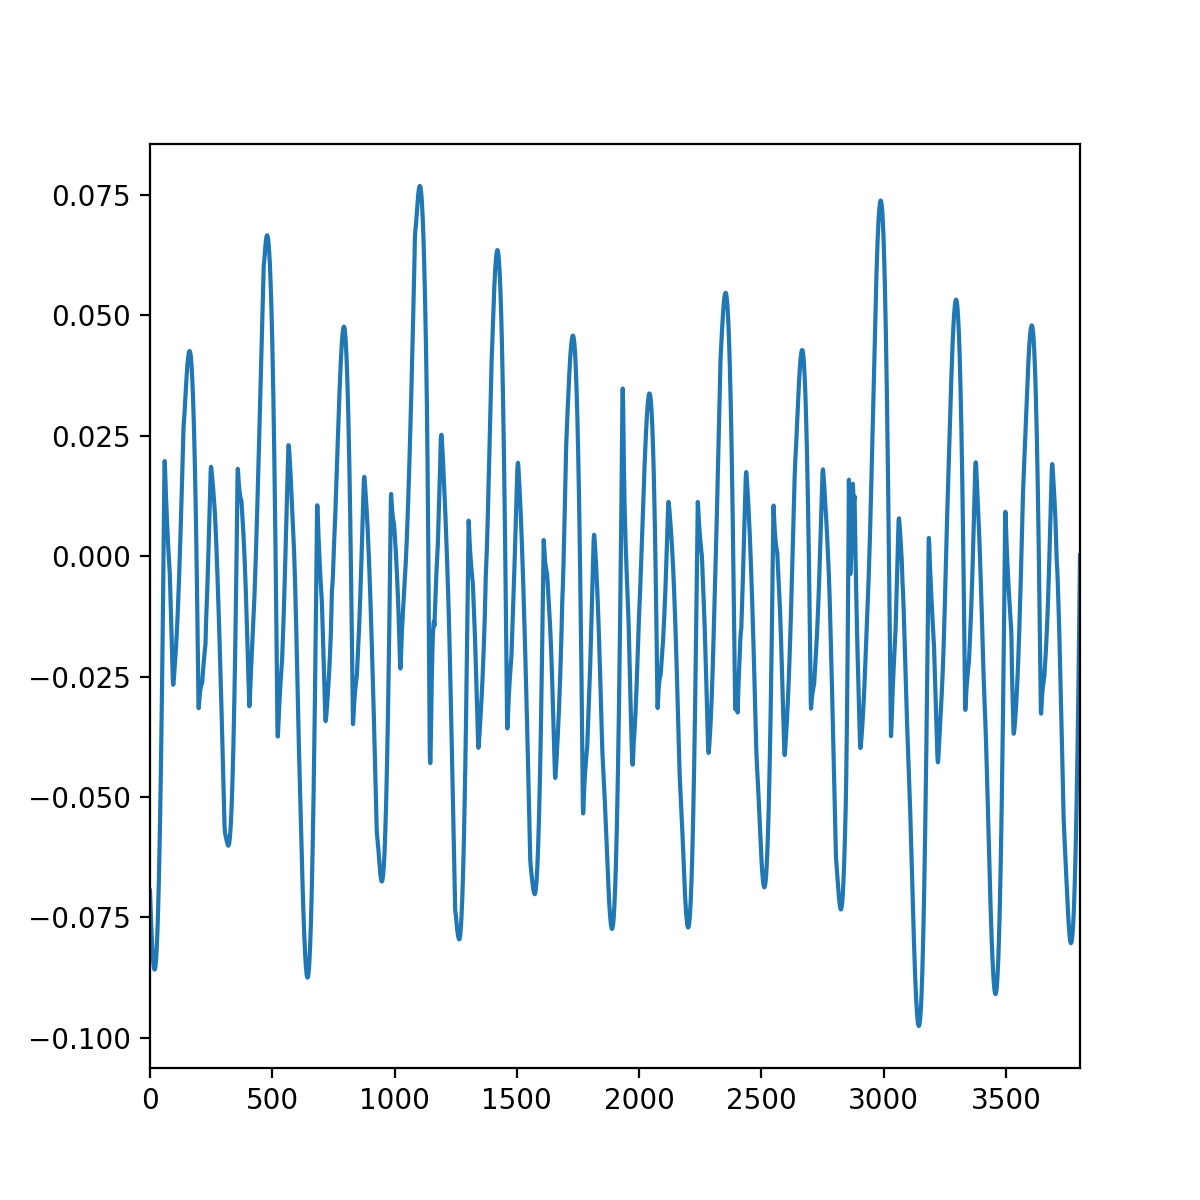

<IPython.core.display.Javascript object>


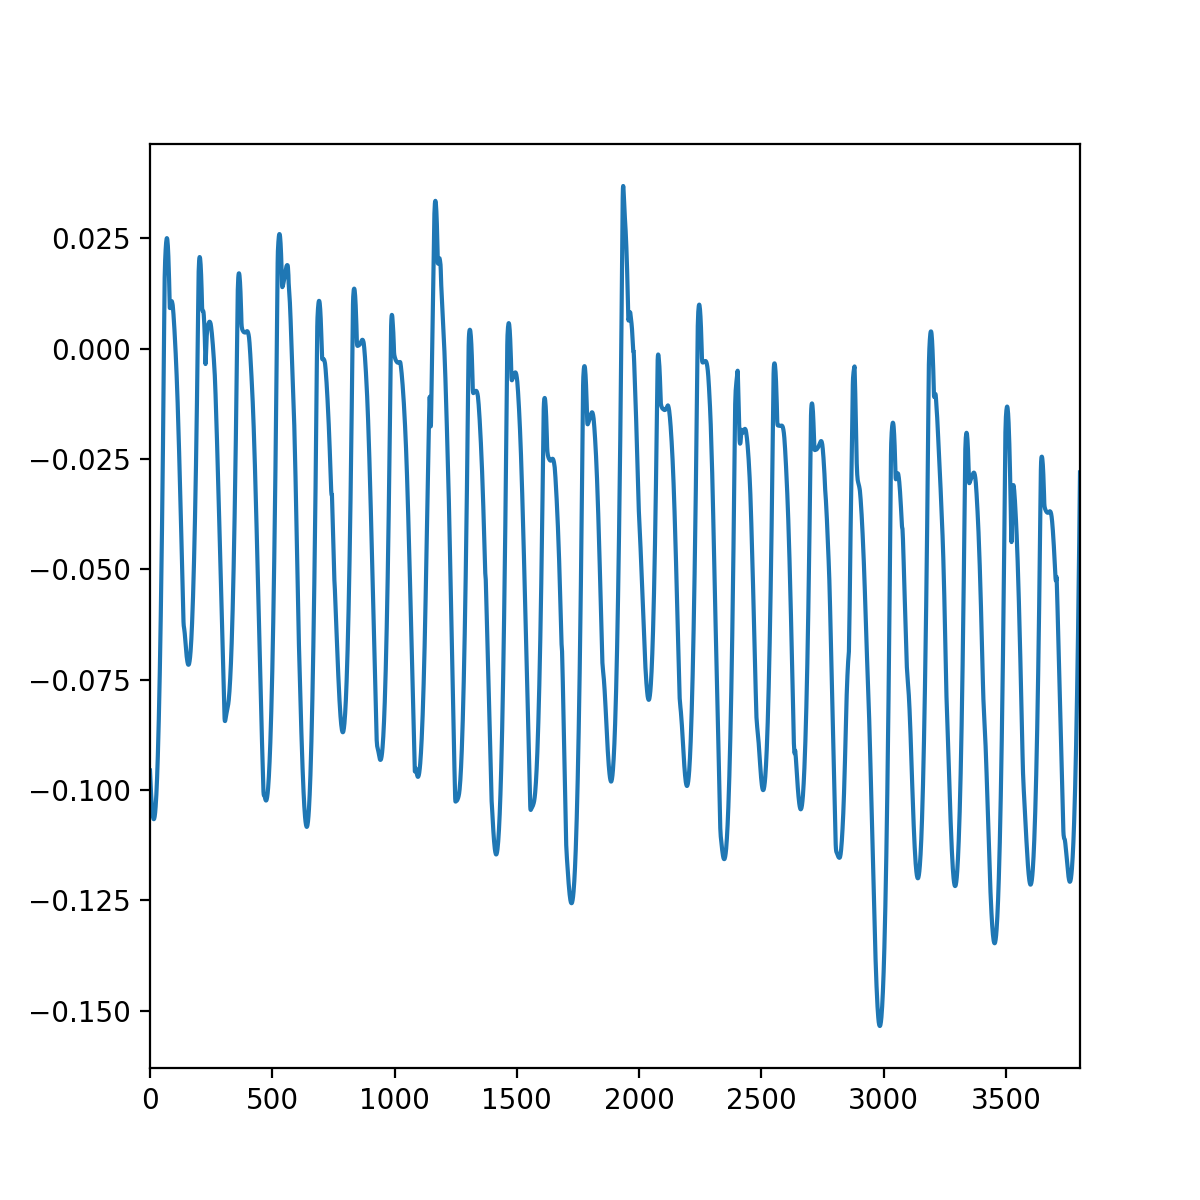

<IPython.core.display.Javascript object>


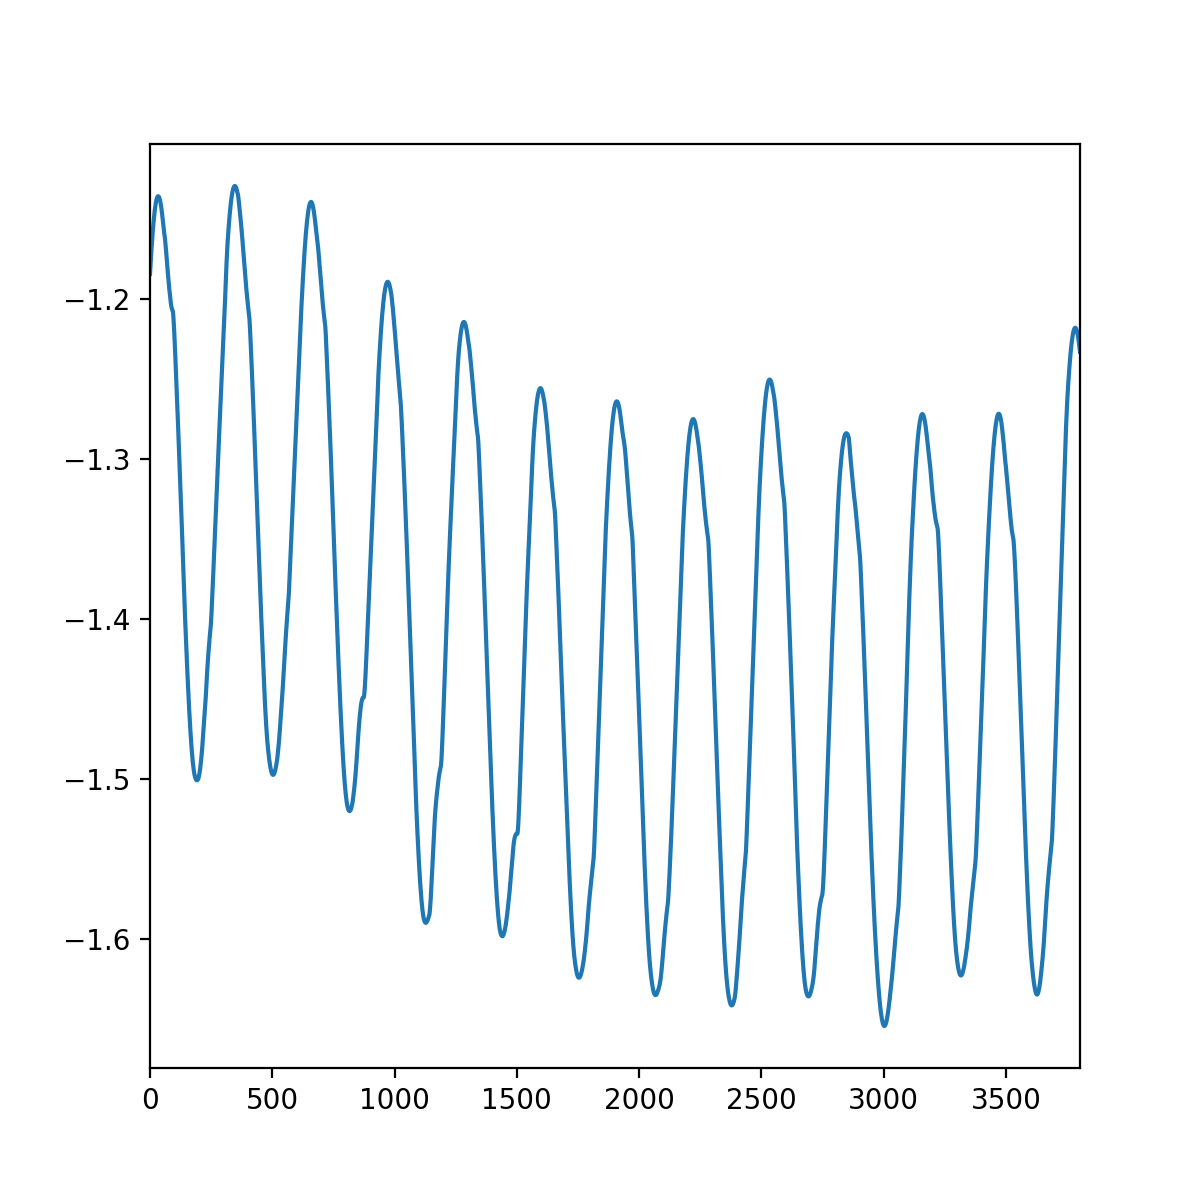

In [84]:
fig = plt.figure()
curr_df['pose__pose_e_orientation_x'].plot()
fig = plt.figure()
curr_df['pose__pose_e_orientation_y'].plot()
fig = plt.figure()
curr_df['pose__pose_e_orientation_z'].plot()

<IPython.core.display.Javascript object>


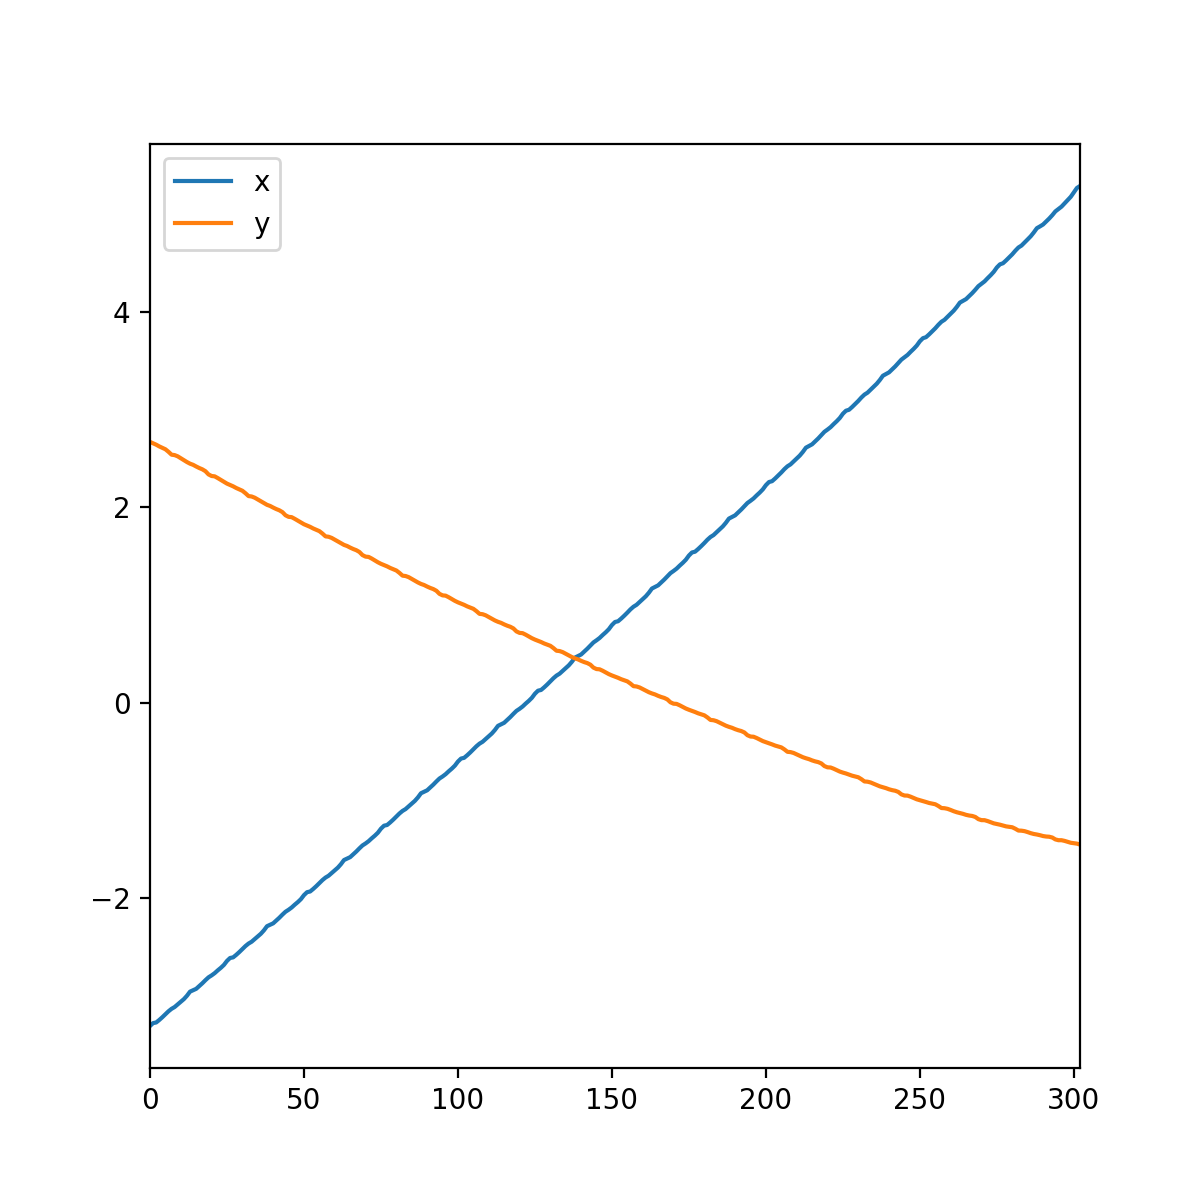

In [73]:
fig = plt.figure()
curr_df['pose__pose_position_x'].plot(label='x')
curr_df['pose__pose_position_y'].plot(label='y')
plt.legend()

<IPython.core.display.Javascript object>


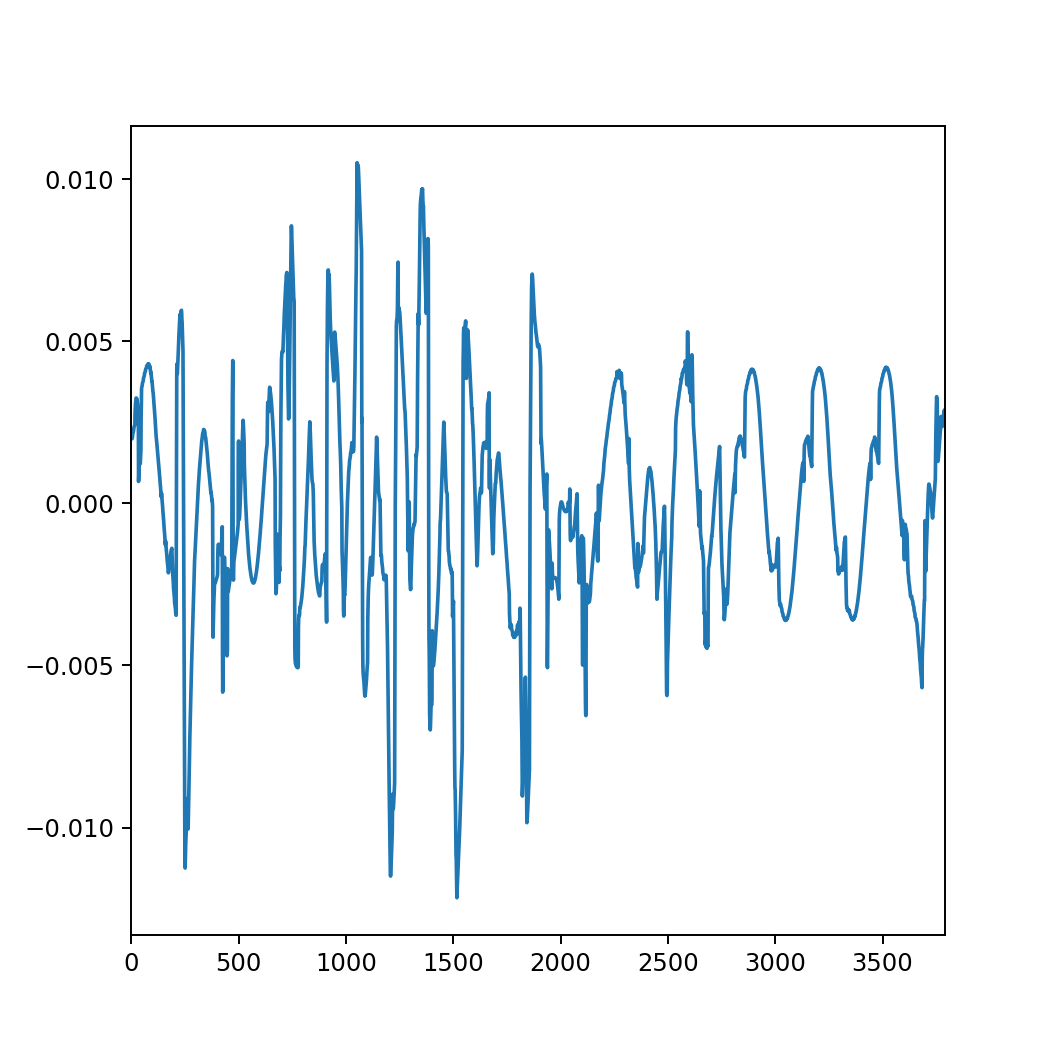

In [59]:
fig = plt.figure()
temp_df = curr_df.rolling(window=2)['pose__pose_e_orientation_z'].apply(lambda x : x[-1] - x[0], raw=True).shift(-2)
temp_df.plot()

# Debug our coordinate function

This is krock on the simulator

![alt]("./images/bars1_krock.jpg")


In [ ]:
def to_hm_coordinates(row, hm, res, tr=[0, 0]):
    x, y = row['pose__pose_position_x'], row['pose__pose_position_y']
    x_max, y_max = hm.shape[0] * res, hm.shape[1] * res
    x_min, y_min = tr

    xs = x + x_min
    ys = -y + y_min

    return pd.Series([xs / res, ys / res])